# Unsupervised Anomaly Detection in Time Series

Anomaly detection can be defined as identification of data points which can be considered as outliers in a specific context. In time-series, most frequently these outliers are either sudden spikes or drops which are not consistent with the data properties (trend, seasonality). Outliers can also be shifts in trends or increases in variance. This problem can be approached in supervised (with labeled data) and unsuperised fashion (without labeled data). However, in the most real-life scenarios, access to the labeled data is scarce and the anomalous patterns may change. Due to these two reasons most of the businesses (that I know of) choose to implement the unsupervised models.
* Rolling Averages
* Auto-Regressive (AR)
* Models Seasonal Models

These algorithms are time-series specific and are based on time-series properties. Rolling Averages approach compares the rolling average at time t with the previous values of the average, and if the difference gets too large - the point gets flagged as outlier. The Auto-Regressive approach to anomaly detection is more sophisticated and builds an AR model to explain the time-series. Then it finds the residuals which are above a certain threshold and these become our outliers. Seasonal Model makes use of a classical econometrics technique called seasonal decomposition (see below). It separates trend and seasonality from the data which leaves us again with the residuals. Then we apply the same appraoch as with AR model and find the outliers.

### Anomaly Detection Toolkit (ADTK) 
ADTK is a Python package for unsupervised / rule-based time series anomaly detection.

As the nature of anomaly varies over different cases, a model may not work universally for all anomaly detection problems. Choosing and combining detection algorithms (detectors), feature engineering methods (transformers), and ensemble methods (aggregators) properly is the key to build an effective anomaly detection model.

In [2]:
!pip install adtk

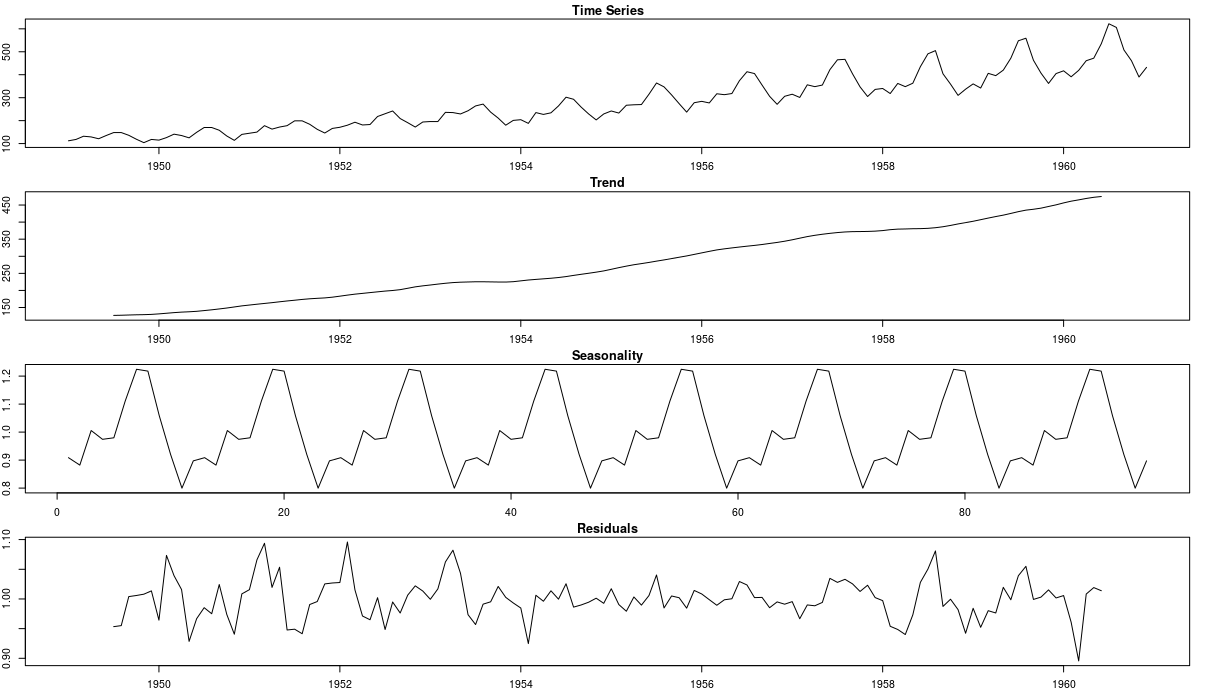

In [3]:
from IPython.display import Image
Image('https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/decomp.png')

In [4]:
#Utility
import pandas as pd
import numpy as np
from datetime import datetime

#Anomaly Detection ADTK
from adtk.detector import PersistAD
from adtk.detector import SeasonalAD
from adtk.detector import AutoregressionAD

#Anomaly Detection ML
from sklearn.neighbors import LocalOutlierFactor

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
from adtk.visualization import plot
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams["figure.figsize"] = (20,10)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

In [5]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/wiki_ts.csv

--2020-10-05 11:10:08--  https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/wiki_ts.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.150.42
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.150.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278011802 (265M) [application/vnd.ms-excel]
Saving to: ‘wiki_ts.csv’

wiki_ts.csv         100%[===================>] 265.13M  42.2MB/s    in 6.1s    

2020-10-05 11:10:14 (43.8 MB/s) - ‘wiki_ts.csv’ saved [278011802/278011802]



In [6]:
df = pd.read_csv('wiki_ts.csv')
df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,12.0,13.0,3.0,5.0,10.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

The first two lines should print There is 145063 websites, with visitis between 2015-07-01 and 2016-12-31. The data here is represented as dataframe with each row being the web traffic time-series for a particular website. After filtering out the time-series with NA values, here’s how the data should look like:

We can see that the data is represented as: each row is a website, and each column is a day.

In [7]:
print(f'There is {df.shape[0]} websites, with visitis between {df.columns[1]} and {df.columns[-1]}')

There is 145063 websites, with visitis between 2015-07-01 and 2016-12-31


We can also see that there are missing values in some of the websites. Let's filter out the timeseries where we have missing values, because we don't really need them to show the anomaly detection algorithms.

In [8]:
no_nas = df.loc[(df.isna().sum(axis=1) == 0), :]

In [9]:
no_nas.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,7.0,12.0,11.0,7.0,9.0,6.0,10.0,8.0,13.0,3.0,14.0,4.0,9.0,14.0,10.0,8.0,3.0,74.0,17.0,8.0,6.0,9.0,3.0,10.0,21.0,9.0,5.0,3.0,4.0,1.0,...,16.0,15.0,16.0,23.0,30.0,12.0,6.0,17.0,17.0,18.0,15.0,19.0,35.0,16.0,25.0,13.0,19.0,15.0,25.0,135.0,22.0,18.0,12.0,21.0,16.0,52.0,24.0,15.0,28.0,17.0,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


Now, let's plot a random website traffic to see how the data looks like

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


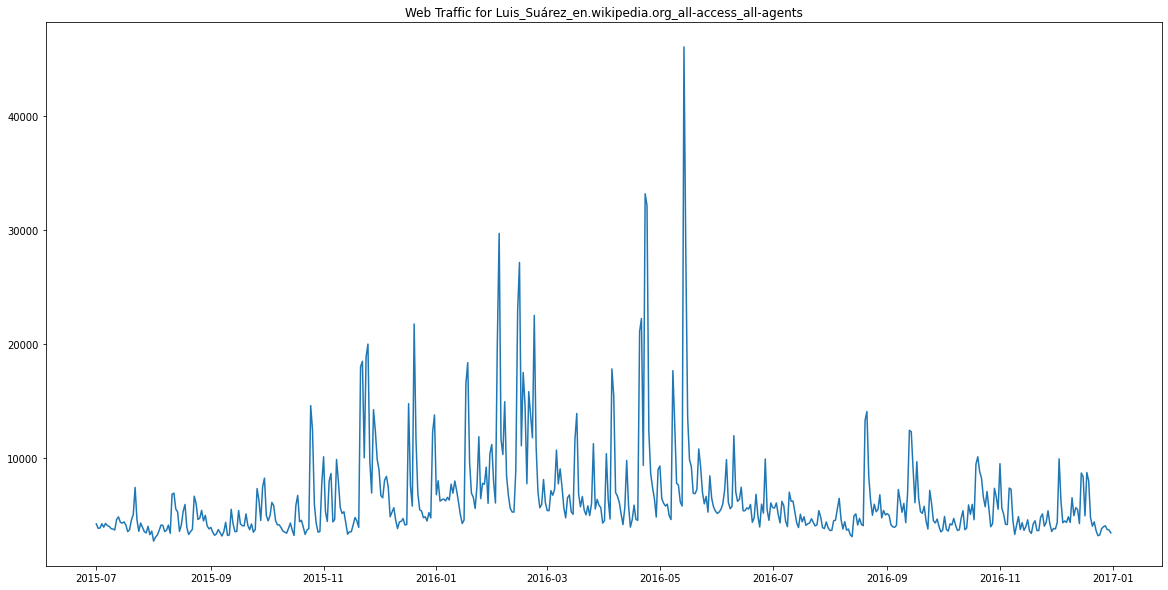

In [10]:
wiki_sample = no_nas.sample(random_state=42).iloc[:, 1:]
x = pd.to_datetime(wiki_sample.columns.ravel())
y = wiki_sample.values.ravel()

plt.title(f'Web Traffic for {no_nas.sample(random_state=42).iloc[:, 0].values[0]}')
sns.lineplot(x, y)

This timeseries representes the traffic on the Luis Suarez wikipage (he's footabl player for Barcelona). It has quite a few spikes, which might be explained by the footbal season activity and his performance in the matches. For example, detecting these spikes might be useful in forecasting demand for his merchendise. Let's take a look at another timeseries for future analysis.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


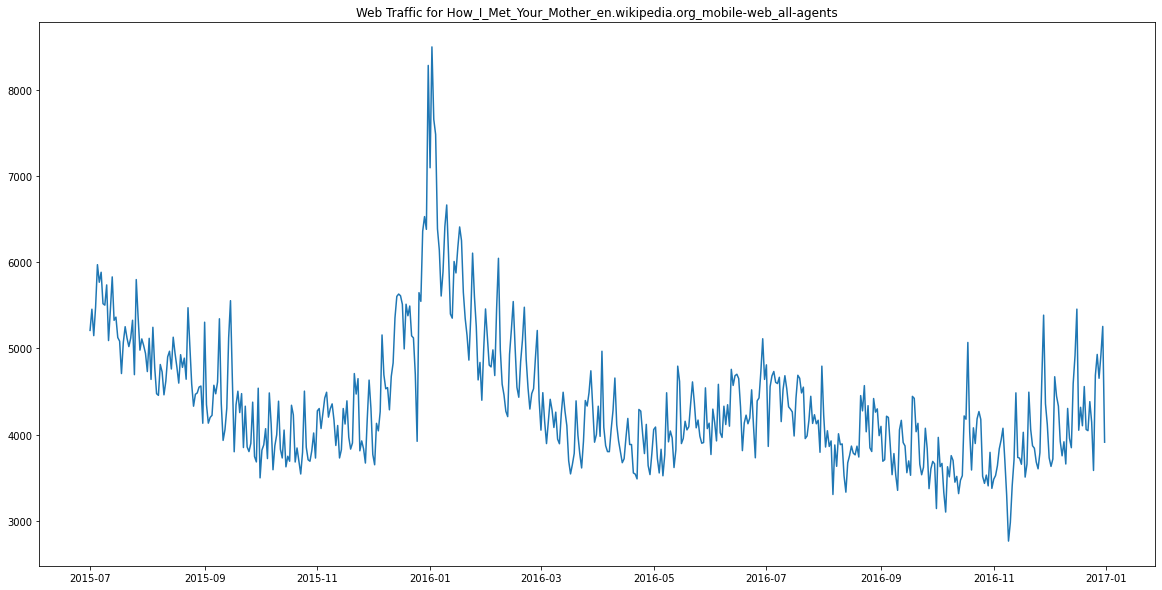

In [11]:
wiki_sample = no_nas.sample(random_state=33333).iloc[:, 1:]
x2 = pd.to_datetime(wiki_sample.columns.ravel())
y2 = wiki_sample.values.ravel()

plt.title(f'Web Traffic for {no_nas.sample(random_state=33333).iloc[:, 0].values[0]}')
sns.lineplot(x2, y2)

This time series is for a TV-show How I Met Your Mother. We can see that it has some sort of a seasonal pattern which might be connected to the broadcasting scheduel. Understadning the anomalies here might be useful in evaluating the success of different episode.

## Anomaly Detection with ADTK: Rolling Average, Auto-regressive, and Seasonal Models

These three methods are the first approaches to try when working with time-series. Rolling average (denoted as `persistAD` in `adtk` package) is the simplest of these approaches but it can work surprisingly well when the data is not very complicated. When the Rolling Average approach fails, Auto-Regressive and Seasonal approaches may performa better because most of the time-series are indeed generated by the auto-regressive processes, and some of them have a seasonal component.
* **Rolling Average** approach compares the current value with the average of preceeding period. If the change in rolling averages is too large, this point is considered as anomaly. 
* **Auto-regressive** model builds a regression model in the background with lagged values of a time-series. The points which cannot be accurately predicted by the AR model are considered as outliers. 
* **Seasonal model** decomposes the time-series into the trend, seasonal, and residual components. If residual component is abnormally large, we can say that this point is an outlier. 

In [12]:
s1 = pd.Series(data=y, index=x)
s2 = pd.Series(data=y2, index=x2)

### Rolling Average

In [13]:
persist_ad = PersistAD(window=7, c=3, side='both')

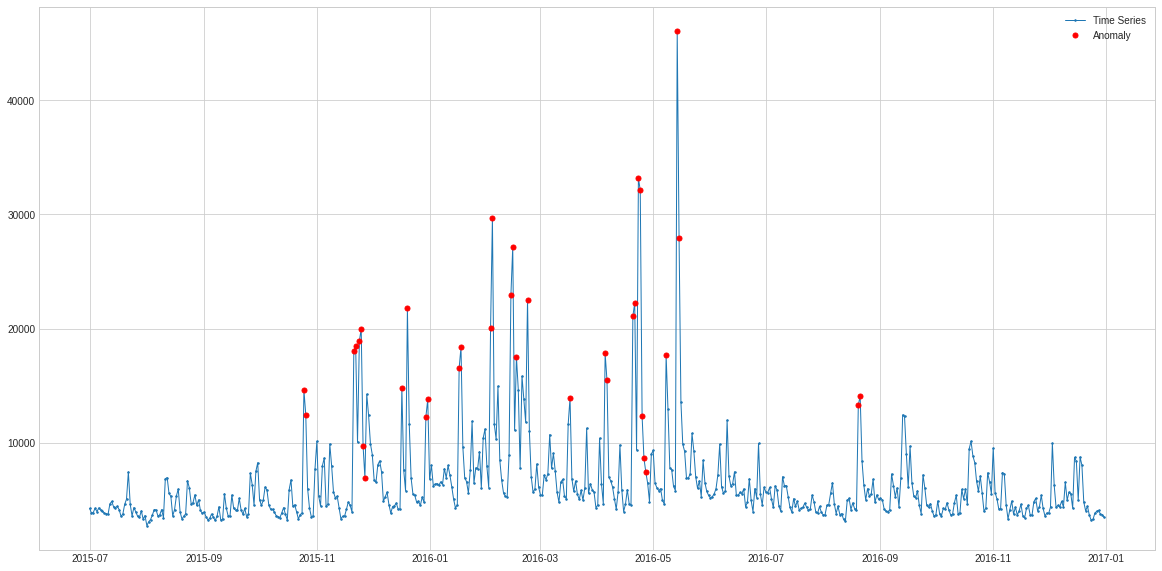

In [15]:
anomalies1 = persist_ad.fit_detect(s1)
plot(s1, anomaly=anomalies1, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Here I'm using 7 day rolling averages to find the outliers. We can see that the highlighted points are indeed spikes in the time-series and could be considered as outliers. Hence, the simplest approach already does a pretty good job at finding the anomalies. Let's see how it performs with seasonal data.

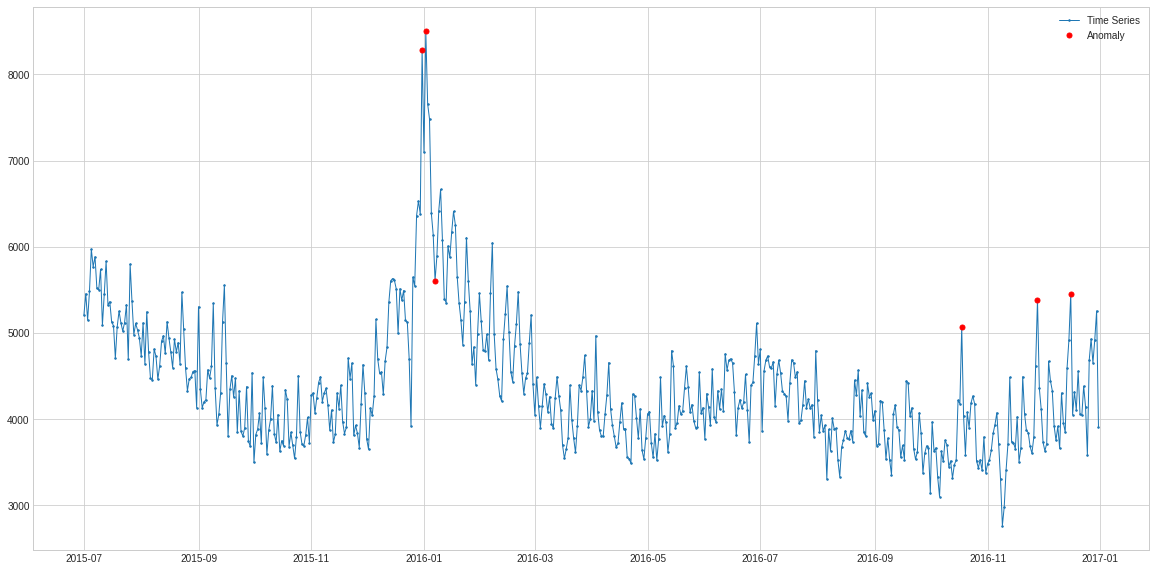

In [16]:
anomalies2 = persist_ad.fit_detect(s2)
plot(s2, anomaly=anomalies2, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Here, the model also picks up the main outlier spikes (christmas and new year) and it also highlights some of the spikes closer to the end of time-series. You will need some business context to understand whether these are indeed outliers or they were mislabeled. But overall, the Moving Average approach does a decent job at this dataset.

### Seasonal

The only parameter that seasonalAD needs is the freq. This paramter determines the frequency of the dataset which helps it to find the appropriate seasonality. It can be inferred automatically but your data must have no missing periods.

In [17]:
seasonal_ad = SeasonalAD(c=3.0, side="both")

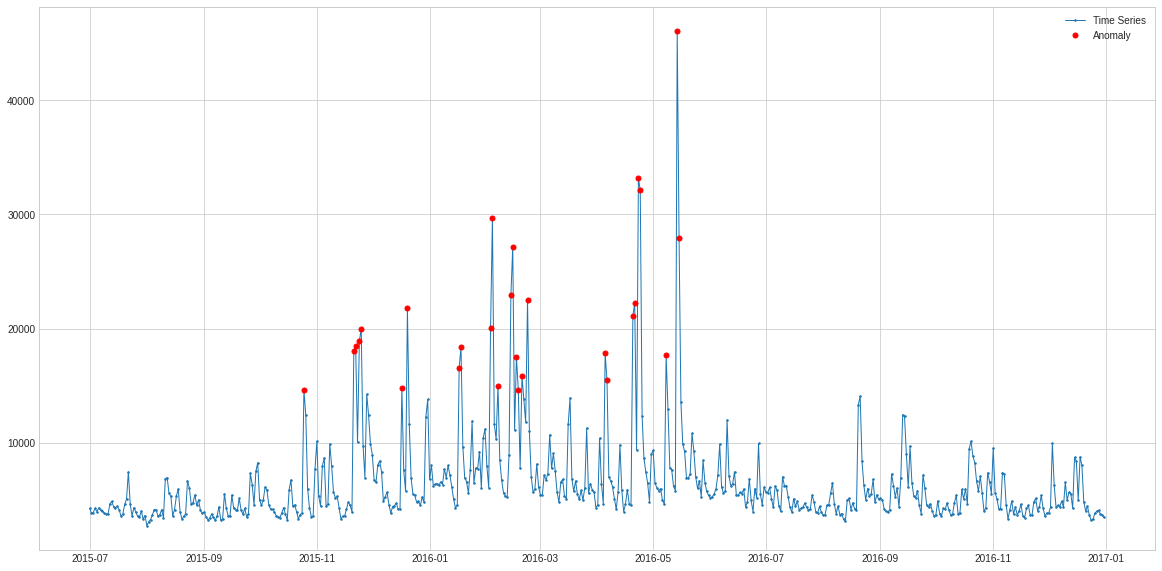

In [18]:
anomalies_season1 = seasonal_ad.fit_detect(s1)
plot(s1, anomaly=anomalies_season1, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Comparing to Rolling Averages approach, Seasonal model is a lot more consistent in the outliers it identifies. These are the spikes which do not match seasonal pattern. That's why we can see some of the spikes not highilghted - these are seasonal spikes and not outliers. In this sense, the model highlights less points, but these points are more likely to be outliers.

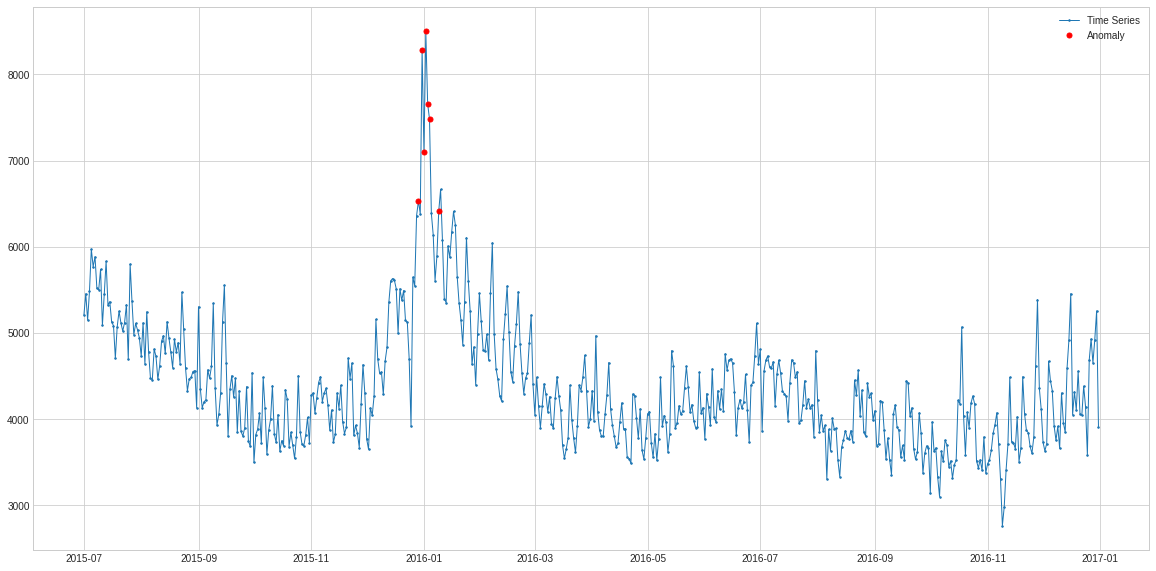

In [19]:
anomalies_season2 = seasonal_ad.fit_detect(s2)
plot(s2, anomaly=anomalies_season2, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Here again, the key outliers are highlighted meaning that the spike during the Christmas period of 2015 is abnormal. But the seasonal model doesn't highlight the December 2016 spikes, meaning that these spikes are in-line with seasonal expectation of a model. If we look closely at the time series, we can see that indeed during the December period wee can expect larger number of visits. Hence, the Seasonal model again is more likely to be correct than simple Moving Averages. 

### Auto-Regressive

To use the AR model, we first need to determine the number of lags to use. For this, we can use ACF plots.

To determine how many lags do we need to include, let's check the autocorrelation of both of these time series.

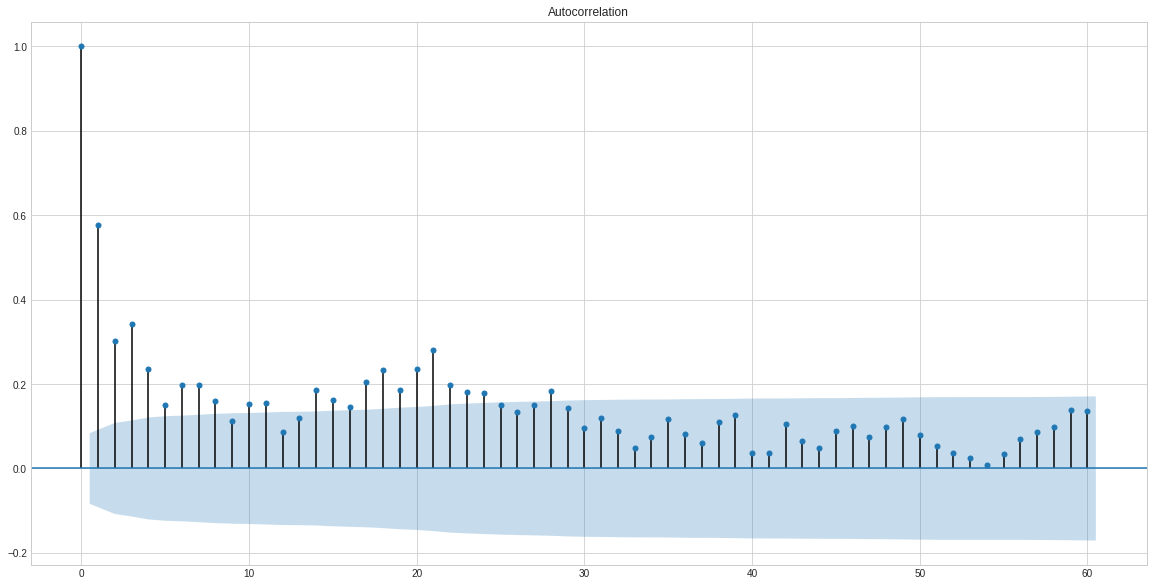

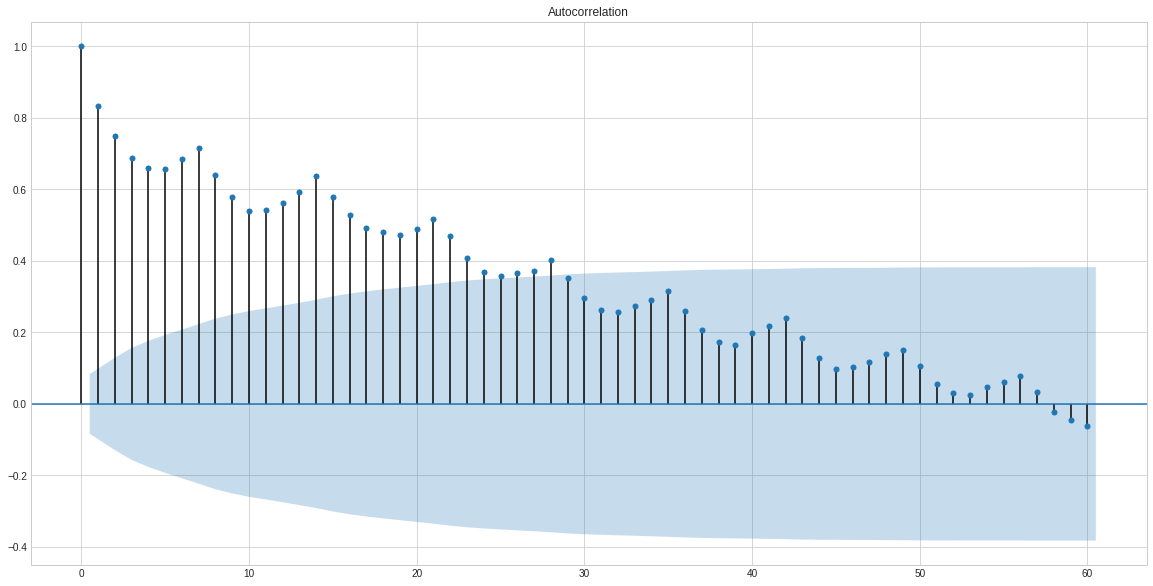

In [20]:
acf = plot_acf(s1, lags = 60)
acf = plot_acf(s2, lags = 60)

Looks like including 30 time steps will be enough to capture the time-dependence of this time-series.

In [22]:
autoregression_ad = AutoregressionAD(n_steps=30, step_size=1, c=3.0)

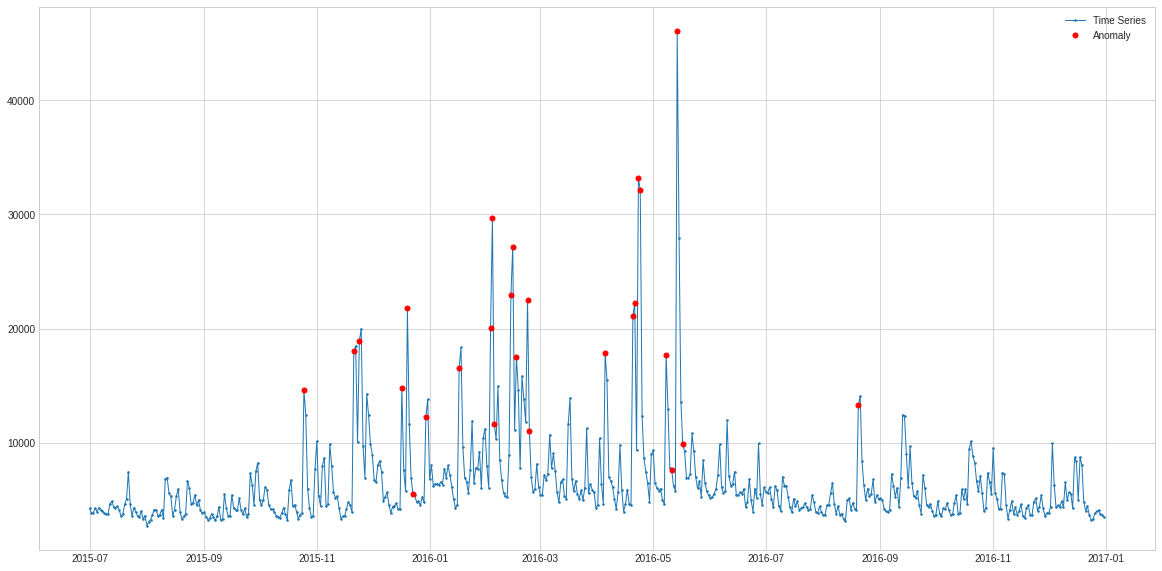

In [23]:
anomalies_ar1 = autoregression_ad.fit_detect(s1.resample('D').sum())
plot(s1, anomaly=anomalies_ar1, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

The AR model is able to capture spikes and performs quite similarly to the Rolling-Average approach. 

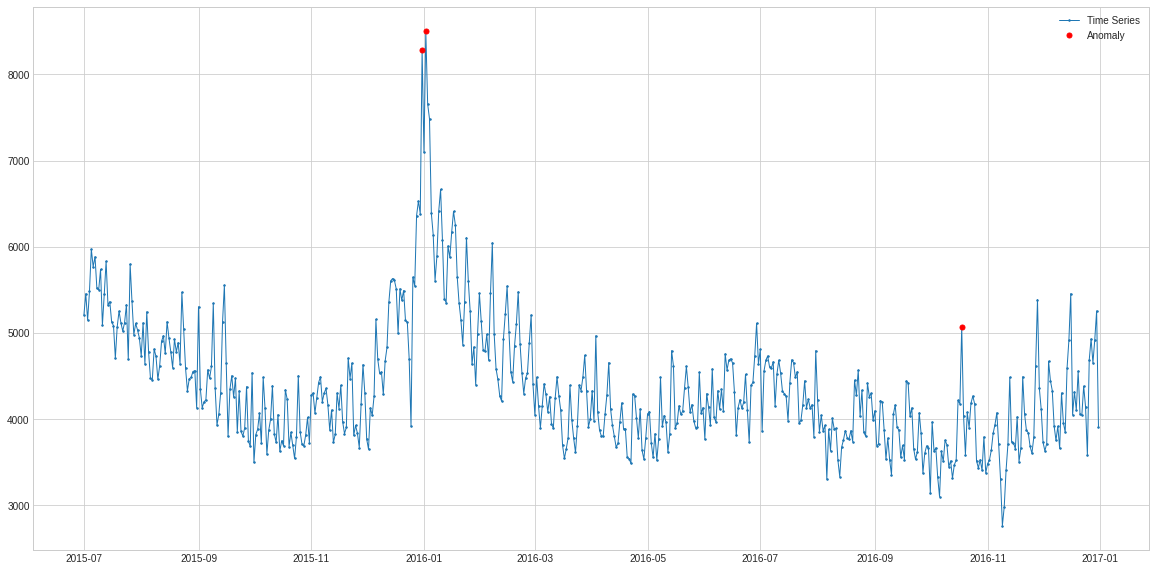

In [24]:
anomalies_ar2 = autoregression_ad.fit_detect(s2.resample('D').sum())
plot(s2, anomaly=anomalies_ar2, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

On this dataset, AR finds two areas of anomaly, similar to the Rolling Average. However, while the Rollign Average has identified multiple points closer to the end of the series, AR only finds the most important one - the one where the shift happens. Again, there is no saying which model is the most correct without a labeled dataset. 

Till now ve'ha seen 3 different algorithms for anomaly detection in time-series data. Because the dataset is not labelled we cannot conclude which method performs the best on these series, but we can see the differences between the detected data points. Ultimately, it all depends on how does your website traffic data look like and what particular outliers you want to detect. This checklist should somewhat help you in determining the methodology to use:

* Is there seasonality in your data? - If yes, try Seasonal Model

* Is your data auto-correlated? - If yes, try Auto-Regressive Model
* Is your data noisy? - If yes, try Rolling Averages
* Are you looking for local or more global outliers? - If local - use Rolling Averages with small window. If global - use larger window.

## Anomaly Detection with ML: Density Based and Isolation Forest


We've seen more classical approaches to anomaly detection. They utilise some of the time-series’ properties (moving averages, auto-regression, seasonality) and they are quite efficient and accurate. However, there might be cases when we need to add some additional context variables (e.g. type of products, weather) that are relevant to the task or when these algorithms are unable to detect some outliers. In these cases, it’s good to have additional algorithms in your toolkit that use somewhat different approaches in detecting the anomalies. Here, I’m going to cover 3 new algorithms:

* Local Outlier Factor (LOF)
* Global Local Outlier Score in Hierarchies (GLOSH)
* Isolation Forest

The two first models are based on the concepts of distance and density. LOF algorithm (Breunig et al., 2000) gives each point a density score which is determined by its proximity to other data points. Proximity is usually measured by Euclidean distance but it can be other metric as well. Clusters with very high density are considered to be normal, whereas points which belong to the regions with lowest density are considered to be outliers. GLOSH (Campello et al., 2015) is further improvement of this approach and it based on hierarchical estimates. These two approaches work in practice because they can detect local outliers. This means that they will flag not only the most obvious spikes and drops but they will also detect outliers in specific contexts (e.g. holidays) that can look abnormal.

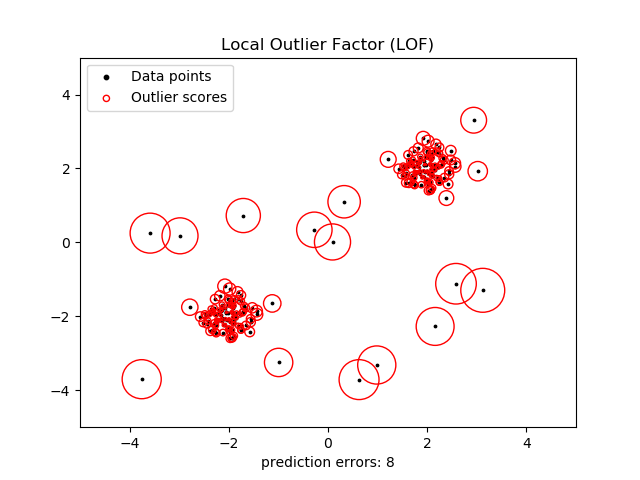

In [25]:
Image('https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/lof.png')

Finally, Isolation Forest (Liu et al., 2008) is a tree-based method that builds a number of decision trees and parses through the data chossing the best splits (based on entropy or information gain). It then measures how deep a tree has to be for a data point to be isolated, averages this depth score across the trees, and find the outliers. Outliers are those with the smallest depth score because they were among the easiest to be isolated (e.g. in the first or second splits).

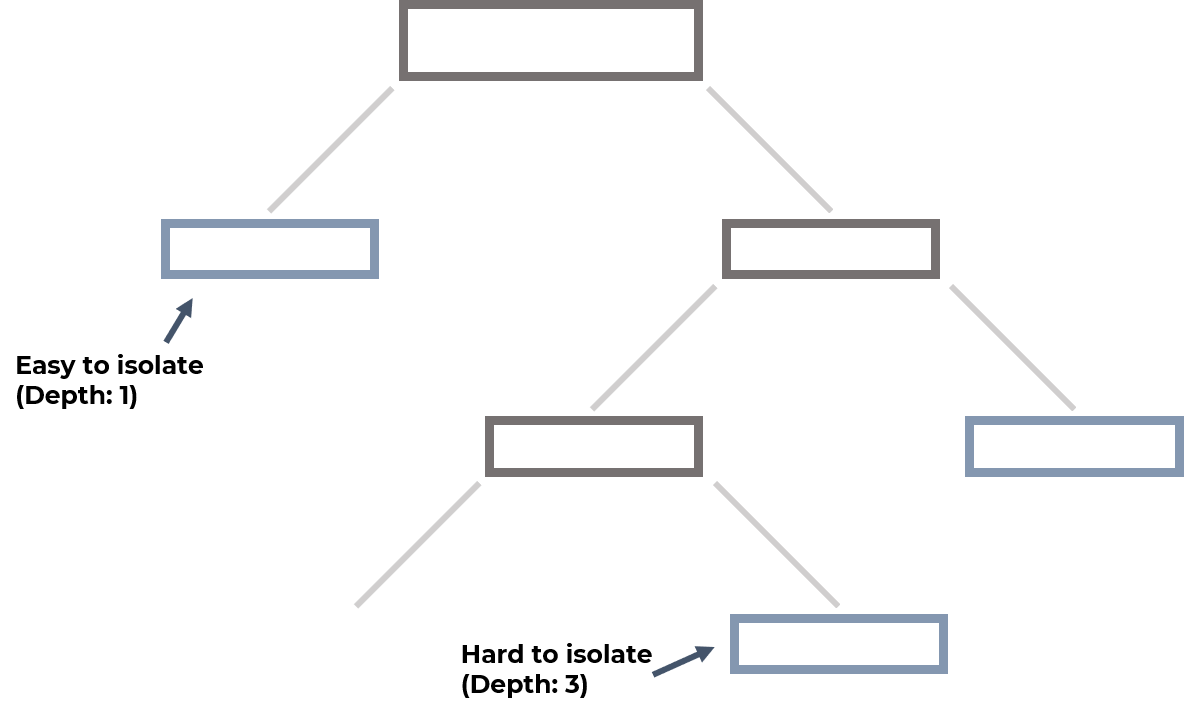

In [26]:
Image('https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/isolation_f.png')

### Local Outlier Factor (LOF)


The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

Thankfully, sklearn’s API is intuitive and well documented, so fitting the model is quite easy. The only parameter that you might want to provide is the contamination rate which helps the algorithm to understand how many outliers you expect to find. This will determin the boundaries that the LOF builds. Here, we’re going to use the default auto but if you know approximately the proportion of outliers, feel free to provide it.

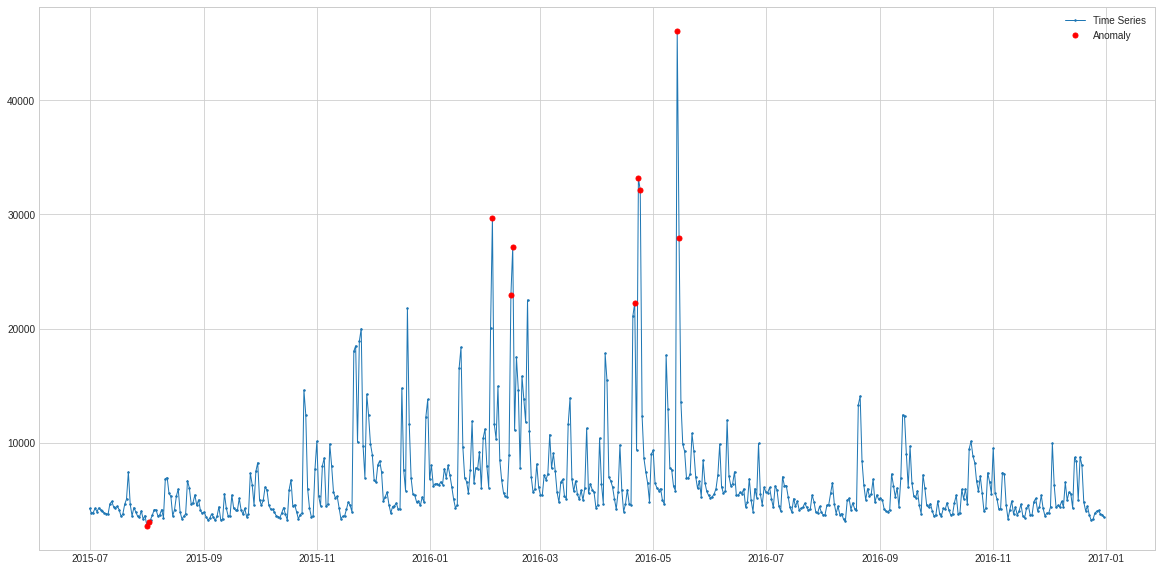

In [28]:
from sklearn.neighbors import LocalOutlierFactor
from adtk.visualization import plot

clf = LocalOutlierFactor(contamination='auto')
lof_outliers1 = clf.fit_predict(np.array(s1).reshape(-1,1))
lof_outliers1 = pd.Series([x == -1 for x in lof_outliers1], index=s1.index)
plot(s1, anomaly=lof_outliers1, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

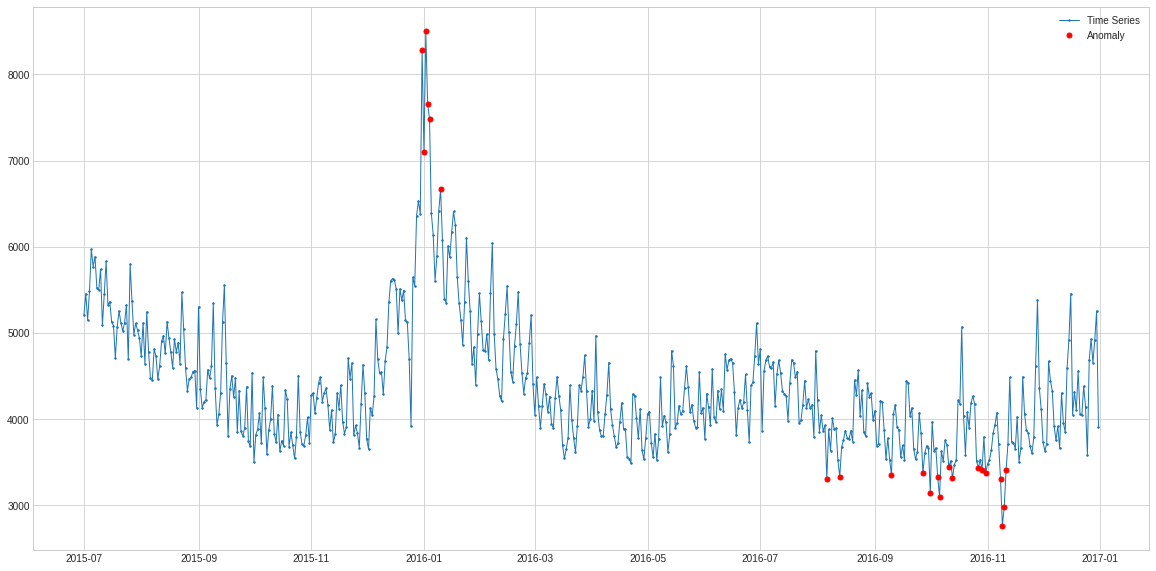

In [32]:
lof_outliers2 = clf.fit_predict(np.array(s2).reshape(-1,1))
lof_outliers2 = pd.Series([x == -1 for x in lof_outliers2], index=s2.index)
plot(s2, anomaly=lof_outliers2, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Here the performance is again in-line with what we saw previously. It finds the main outlier peak and it also detects the lower points at the end of the series. Because these points are indeed lower than anything we have seen in the series, they might be considered as anomalies or, at least, they should be detected. Overall, this algorithm has provided a new perspective on our time-series data simply because it uses another logic under the hood. This just further illustrates how important it is to know your data and your expected outliers.


### Density Based: HDBSCAN GLOSH
Because HDBSCAN is density-based algorithm, they’ve provided an easy way of calculating the outlier scores according to GLOSH algorithm. Let’s see how we can get these scores and what to do next with them




In [30]:
!pip install hdbscan

     |████████████████████████████████| 4.7MB 8.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2301831 sha256=c611aa89d8310188404792d51d5a49e12aeb917fced2686986714dfa607dd54e
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


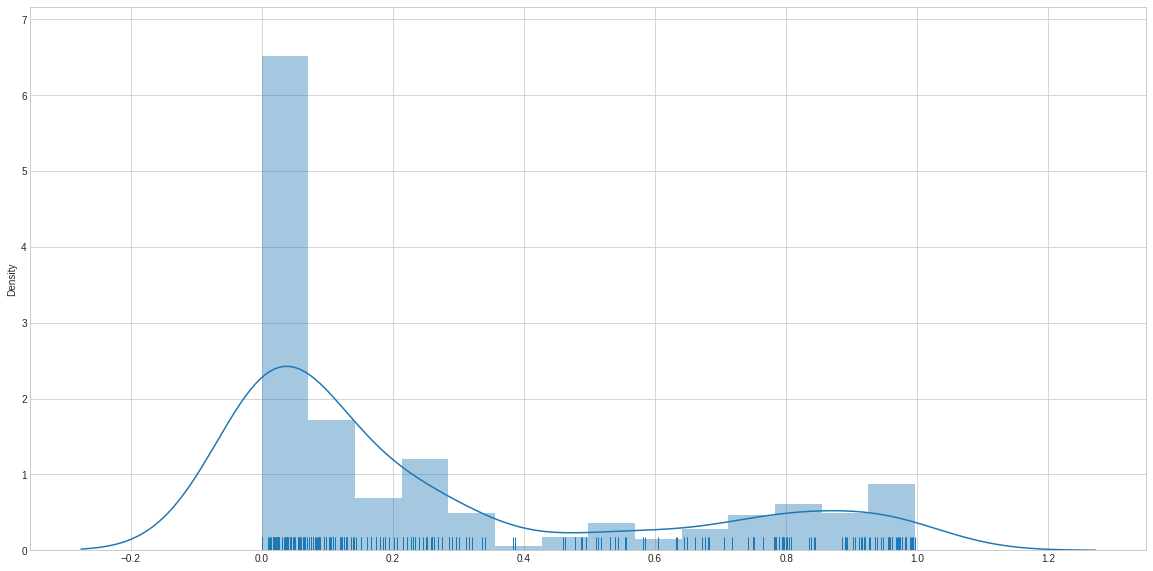

In [31]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(np.array(s1).reshape(-1,1))
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

In the distribution of outlier scores we can already see that the right outlier tail is quite significant. Let's plot the outliers which belong to the top 10% according to this score.

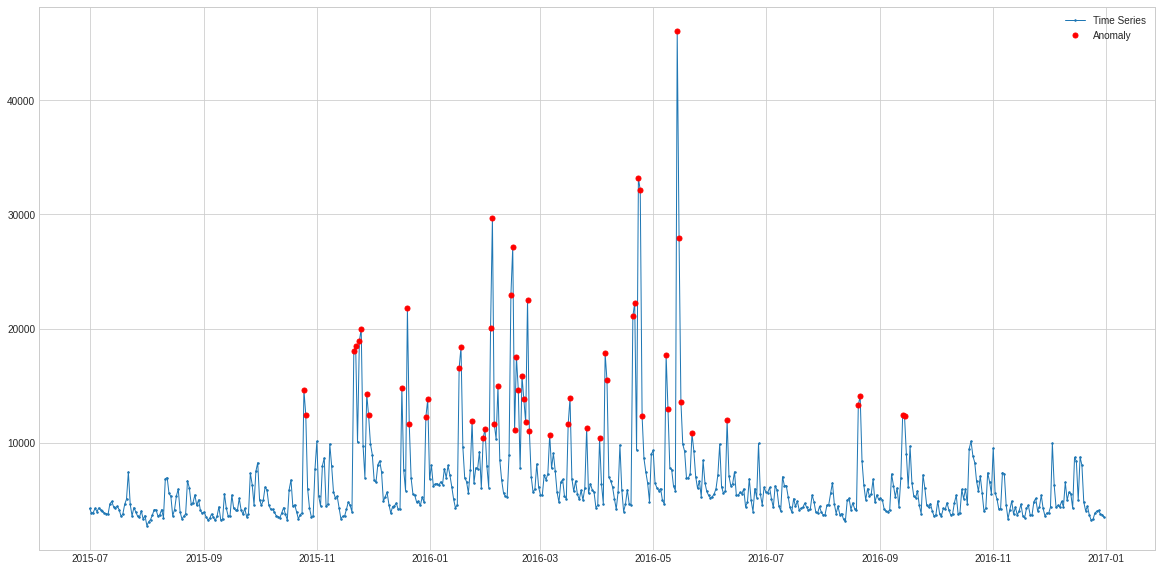

In [33]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
outliers = s1[outliers]
outliers_series = pd.Series(s1.index.isin(outliers.index), index=s1.index)
plot(s1, anomaly=outliers_series, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Overall, the HDBSCAN does a pretty good job at detecting the spikes and it's also moe consistent as it detects mostly the spikes and not the falls after the spikes. Let's see how it performs on the seasonal dataset.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


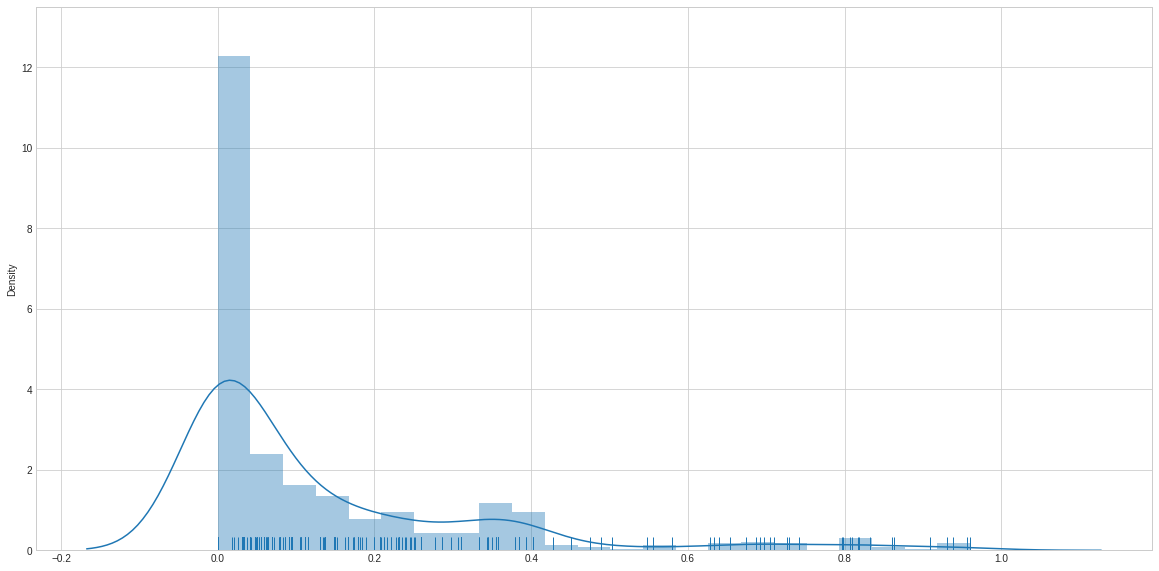

In [34]:
clusterer2 = hdbscan.HDBSCAN(min_cluster_size=15).fit(np.array(s2).reshape(-1,1))
sns.distplot(clusterer2.outlier_scores_[np.isfinite(clusterer2.outlier_scores_)], rug=True)

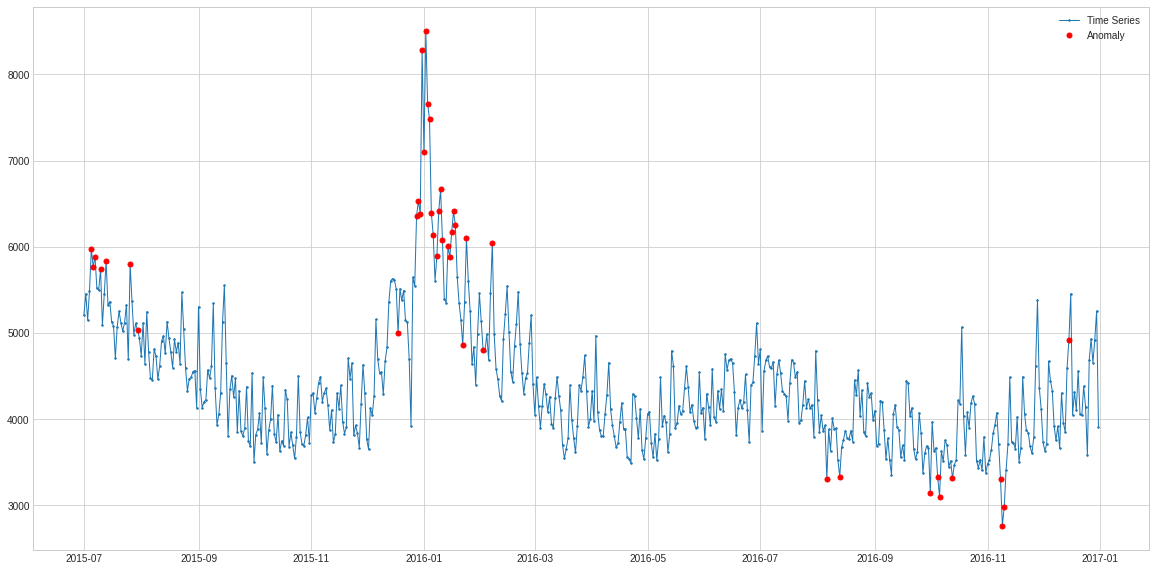

In [35]:
threshold2 = pd.Series(clusterer2.outlier_scores_).quantile(0.90)
outliers2 = np.where(clusterer2.outlier_scores_ > threshold2)[0]
outliers2 = s2[outliers2]
outliers_series2 = pd.Series(s2.index.isin(outliers2.index), index=s2.index)
plot(s2, anomaly=outliers_series2, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Interstingly, on this dataset, HDBSCAN is the first algorithm to detect also the downturns. On the other hand, it also seems to mislabel some points at the beginning of the series, so it might be an indiciation that we need to increase the quantile from 90% to e.g. 95% or 98%. 

### Isolation Forest
This models also has quite an intuitive implementation in sklearn and the only parameter is to specify is again the contamination rate.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


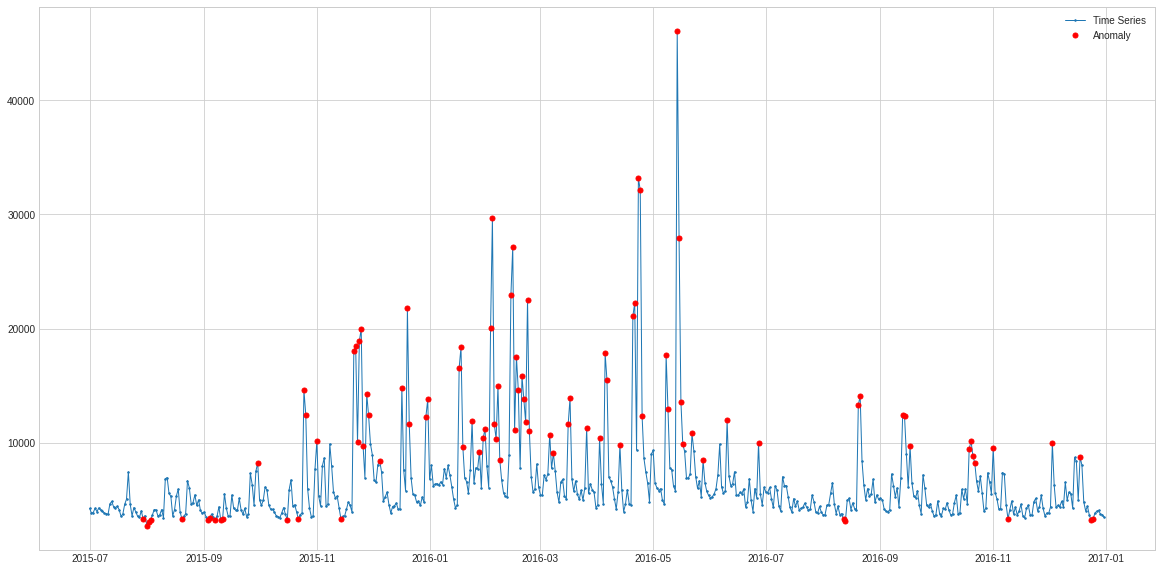

In [36]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination='auto', behaviour="new")
if_outliers1 = clf.fit_predict(np.array(s1).reshape(-1,1))
if_outliers1 = pd.Series([x == -1 for x in if_outliers1], index=s1.index)
plot(s1, anomaly=if_outliers1, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Interestingly, Isolation Forest is able to detect both spikes and drops, and it flags way more datapoints as outliers than previous algorithms. Let’s see its behaviour on another web traffic data.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


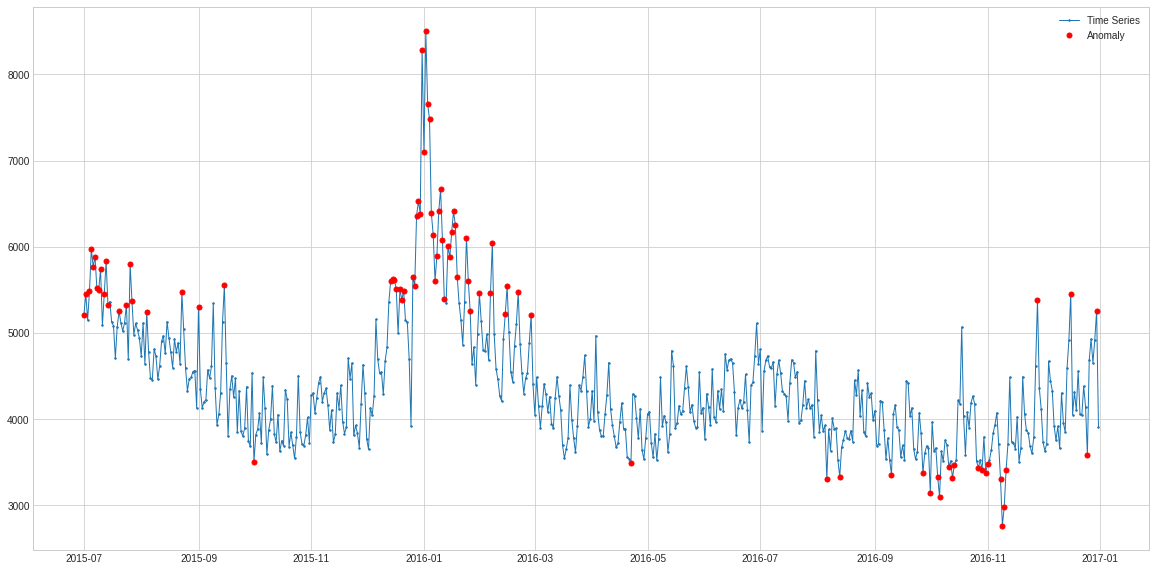

In [37]:
if_outliers2 = clf.fit_predict(np.array(s2).reshape(-1,1))
if_outliers2 = pd.Series([x == -1 for x in if_outliers2], index=s2.index)
plot(s2, anomaly=if_outliers2, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

It seems like the Isolation Forest with default parameters consider too many points as outliers. Changing the contamination proportion should help, but we won't really know this value in production. Hence, this is a key limitation of this algorithm and it may not be suited to find the outliers in these series.

# Evaluation on Labeled Dataset

So far, we’ve seen 6 algorithms (including the previous part) and each of them detects slightly different type of outliers. While there’s clearly no one-size-fits-all approach to this problem, it’d be good to see their performance on a variety of datasets and have some sort of a benchmark study. Exactly for this reason, I’m going to use a labeled dataset from this competition to calculate the F1 scores of different anomaly detection algorithms for a variety of time-series. Let’s read in the data and see how one of the series looks like.

In [38]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/phase2_train.csv

--2020-10-05 11:14:26--  https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/phase2_train.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.150.42
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.150.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176109012 (168M) [application/vnd.ms-excel]
Saving to: ‘phase2_train.csv’

phase2_train.csv    100%[===================>] 167.95M  39.5MB/s    in 4.1s    

2020-10-05 11:14:31 (40.8 MB/s) - ‘phase2_train.csv’ saved [176109012/176109012]



In [39]:
train = pd.read_csv('phase2_train.csv')

First, let's select a single time-series to demonstrate how the data looks like

In [40]:
kpi = 'c69a50cf-ee03-3bd7-831e-407d36c7ee91'
kpi_train = train.loc[train['KPI ID'] == kpi, :]
kpi_train.timestamp = kpi_train.timestamp.apply(lambda x: datetime.fromtimestamp(x))
kpi_train.index = kpi_train.timestamp

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [41]:
#Proportion of anomalies
kpi_train['label'].value_counts(normalize=True)

0    0.993997
1    0.006003
Name: label, dtype: float64

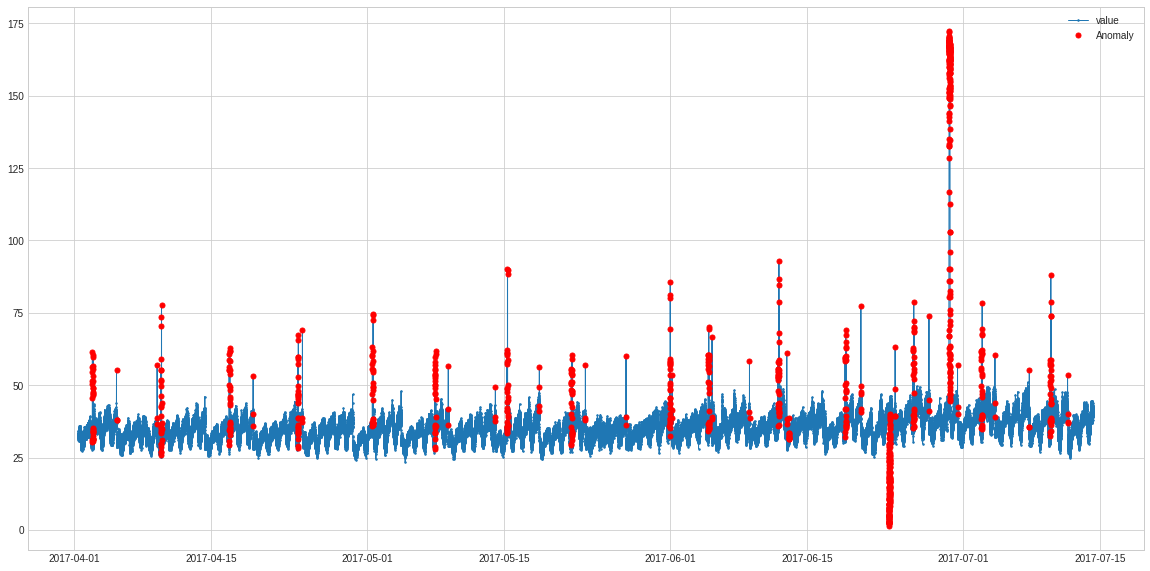

In [42]:
plot(kpi_train.value, anomaly=kpi_train['label'], ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

So here the data is quite seasonal most of the annomalies are sudden spikes or falls after them. In theory, a simple moving average filter should be able to deal with most of them, but our goal is to find the algorithm which works the best across multiple time-series. Hence, let’s now use the models discussed on this and 28 other time-series.

In [43]:
class SeriesAnomalyDetector:
    def rolling_avg(self, data, window):
        persist_ad = PersistAD(window=window, c=3, side='both') #Compares 2 hours means
        persist_anomalies = persist_ad.fit_detect(data)
        return persist_anomalies.fillna(0)
    
    def ar(self, data, n_steps, step_size):
        autoregression_ad = AutoregressionAD(n_steps=n_steps, step_size=step_size, c=3.0)
        ar_anomalies = autoregression_ad.fit_detect(data)
        return ar_anomalies.fillna(0)
    
    def seasonal(self, data):
        seasonal_ad = SeasonalAD(c=3.0, side="both")
        season_anomalies = seasonal_ad.fit_detect(data)
        season_anomalies = season_anomalies[data.index]
        return season_anomalies.fillna(0)
    
    def hdbscan(self, data, q):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(np.array(data).reshape(-1,1))
        threshold = pd.Series(clusterer.outlier_scores_).quantile(q)
        hdbscan_outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
        hdbscan_outliers = data[hdbscan_outliers]
        hdbscan_anomalies = pd.Series(data.index.isin(hdbscan_outliers.index), index=data.index)
        return hdbscan_anomalies.fillna(0)
    
    def lof(self, data, c):
        clf = LocalOutlierFactor(contamination=c)
        lof_outliers = clf.fit_predict(np.array(data).reshape(-1,1))
        lof_anomalies = pd.Series([x == -1 for x in lof_outliers], index=data.index)
        return lof_anomalies.fillna(0)
    
    def isolation_f(self, data, c):
        clf = IsolationForest(contamination=c, behaviour="new")
        if_outliers = clf.fit_predict(np.array(data).reshape(-1,1))
        if_anomalies = pd.Series([x == -1 for x in if_outliers], index=data.index)
        return if_anomalies.fillna(0)

In [44]:
pd.infer_freq(kpi_train.index) == None

True

In [45]:
#Find contamination
c = kpi_train['label'].value_counts(normalize=True)[1]
q = 1-c
if pd.infer_freq(kpi_train.index) == None:
    freq = '1T'
else:
    freq = pd.infer_freq(kpi_train.index)
    
data = kpi_train.value.resample(freq).sum()


detector = SeriesAnomalyDetector()
ra = detector.rolling_avg(data, 60)
ar = detector.ar(data, 60, 1)
seasonal = detector.seasonal(data)
hdb = detector.hdbscan(data, q)
lof = detector.lof(data, c)
isolation_f = detector.isolation_f(data, c)

/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


In [46]:
from sklearn.metrics import f1_score

anomalies = [ra, ar, seasonal, hdb, lof, isolation_f]
methods = ['Rolling Average', 'Auto-Regressive', 'Seasonal Model', 'HDBSCAN', 'LOF', 'Isolation Forest']

for i, a in enumerate(anomalies):

    print(f'{methods[i]} F1 score: {f1_score(kpi_train.label.values,a[kpi_train.label.index])}')

Rolling Average F1 score: 0.45981452859350846
Auto-Regressive F1 score: 0.3463203463203463
Seasonal Model F1 score: 0.7220670391061453
HDBSCAN F1 score: 0.478082992402104
LOF F1 score: 0.06989853438556932
Isolation Forest F1 score: 0.6443259710586443


Now, let's see the performance on all the other series that we have

As you can see from the code, I’m cheating a little bit by providing the actual contamination % . Then, to get actually unbiased results, I’d have to test these algorithms on the test set with the same contamination rates for LOF and Isolation Forest. I’m not going to do this here, but feel free to try it at your own (there is testing dataset at the link as well). The actual detection code looks as follows:

In [47]:
from tqdm import tqdm
#Saving the proportion for later testing
contamination_dict = {}
performance = {}

for kpi in tqdm(train['KPI ID'].unique()):
    #Data Selection
    filt_df = train.loc[train['KPI ID'] == kpi, :]
    filt_df.timestamp = filt_df.timestamp.apply(lambda x: datetime.fromtimestamp(x))
    filt_df.index = filt_df.timestamp
    filt_df = filt_df.sort_index()
    filt_df = filt_df.loc[~filt_df.index.duplicated(keep='first')]
    c = filt_df['label'].value_counts(normalize=True)[1]
    q = 1-c
    data = filt_df.value.resample(pd.infer_freq(filt_df.index[:5])).sum()
    
    #Anomaly detection
    detector = SeriesAnomalyDetector()
    ra = detector.rolling_avg(data, 60)
    ar = detector.ar(data, 60, 1)
    try:
        seasonal = detector.seasonal(data)
    except:
        seasonal = pd.Series(index=data.index).fillna(False)
    hdb = detector.hdbscan(data, q)
    lof = detector.lof(data, c)
    isolation_f = detector.isolation_f(data, c)
    f1_scores = []
    anomalies = [ra, ar, seasonal, hdb, lof, isolation_f]
    methods = ['Rolling Average', 'Auto-Regressive', 'Seasonal Model', 'HDBSCAN', 'LOF', 'Isolation Forest']
    for i, a in enumerate(anomalies):
        f1_scores.append(f1_score(filt_df.label.values, a[filt_df.label.index]))
        print(f'{methods[i]} F1 score: {f1_score(filt_df.label.values, a[filt_df.label.index])}')
    
    #Storing parameters and results
    contamination_dict[kpi] = c
    performance[kpi] = f1_scores

  0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.0697700504767246
Auto-Regressive F1 score: 0.08054823405376911
Seasonal Model F1 score: 0.2842242503259452
HDBSCAN F1 score: 0.08892207439587295


  3%|▎         | 1/29 [00:12<05:51, 12.56s/it]

LOF F1 score: 0.08734572087345721
Isolation Forest F1 score: 0.042966891019103955


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
  7%|▋         | 2/29 [00:13<04:06,  9.14s/it]

Rolling Average F1 score: 0.04166666666666667
Auto-Regressive F1 score: 0.2631578947368421
Seasonal Model F1 score: 0.04210526315789474
HDBSCAN F1 score: 0.04000000000000001
LOF F1 score: 0.04000000000000001
Isolation Forest F1 score: 0.03468208092485548


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
 10%|█         | 3/29 [00:15<02:57,  6.82s/it]

Rolling Average F1 score: 0.0
Auto-Regressive F1 score: 0.11444921316165949
Seasonal Model F1 score: 0.0
HDBSCAN F1 score: 0.010638297872340425
LOF F1 score: 0.13227513227513227
Isolation Forest F1 score: 0.35638297872340424


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning:

Rolling Average F1 score: 0.3287671232876712
Auto-Regressive F1 score: 0.15668202764976957
Seasonal Model F1 score: 0.0
HDBSCAN F1 score: 0.384
LOF F1 score: 0.08
Isolation Forest F1 score: 0.3966942148760331


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
 17%|█▋        | 5/29 [00:17<01:34,  3.96s/it]

Rolling Average F1 score: 0.34853420195439744
Auto-Regressive F1 score: 0.20454545454545453
Seasonal Model F1 score: 0.5138632162661737
HDBSCAN F1 score: 0.12280701754385963
LOF F1 score: 0.08844507845934381
Isolation Forest F1 score: 0.5685714285714285


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
 21%|██        | 6/29 [00:18<01:11,  3.13s/it]

Rolling Average F1 score: 0.14285714285714288
Auto-Regressive F1 score: 0.21052631578947367
Seasonal Model F1 score: 0.14285714285714288
HDBSCAN F1 score: 0.15384615384615385
LOF F1 score: 0.15384615384615385
Isolation Forest F1 score: 0.15384615384615385


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
 24%|██▍       | 7/29 [00:19<00:56,  2.55s/it]

Rolling Average F1 score: 0.0
Auto-Regressive F1 score: 0.18181818181818182
Seasonal Model F1 score: 0.2857142857142857
HDBSCAN F1 score: 0.3333333333333333
LOF F1 score: 0.3333333333333333
Isolation Forest F1 score: 0.3636363636363636


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
 28%|██▊       | 8/29 [00:21<00:45,  2.15s/it]

Rolling Average F1 score: 0.0
Auto-Regressive F1 score: 0.4411764705882353
Seasonal Model F1 score: 0.0
HDBSCAN F1 score: 0.017543859649122806
LOF F1 score: 0.02631578947368421
Isolation Forest F1 score: 0.008771929824561403


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning:

Rolling Average F1 score: 0.012649130372286906
Auto-Regressive F1 score: 0.01569952305246423
Seasonal Model F1 score: 0.0


 31%|███       | 9/29 [02:27<13:10, 39.54s/it]

HDBSCAN F1 score: 0.32407407407407407
LOF F1 score: 0.0
Isolation Forest F1 score: 0.33488372093023255


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.06832074793239842
Auto-Regressive F1 score: 0.041360060898249174
Seasonal Model F1 score: 0.15880522713130055
HDBSCAN F1 score: 0.06340718105423987


 34%|███▍      | 10/29 [02:46<10:33, 33.35s/it]

LOF F1 score: 0.14357535367707236
Isolation Forest F1 score: 0.30760115117657016


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.03581176984386941
Auto-Regressive F1 score: 0.05755555555555555
Seasonal Model F1 score: 0.02285253394273424
HDBSCAN F1 score: 0.03535142658315935


 38%|███▊      | 11/29 [03:05<08:38, 28.83s/it]

LOF F1 score: 0.062128222075346996
Isolation Forest F1 score: 0.2614854517611026


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.02809278350515464
Auto-Regressive F1 score: 0.029976836081209973
Seasonal Model F1 score: 0.009581881533101045
HDBSCAN F1 score: 0.027027027027027032


 41%|████▏     | 12/29 [03:21<07:05, 25.04s/it]

LOF F1 score: 0.04702738810955243
Isolation Forest F1 score: 0.3751429660693862


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning:

Rolling Average F1 score: 0.1061836352279825
Auto-Regressive F1 score: 0.013435833506475517
Seasonal Model F1 score: 0.0


 45%|████▍     | 13/29 [05:35<15:24, 57.76s/it]

HDBSCAN F1 score: 0.36792452830188677
LOF F1 score: 0.0
Isolation Forest F1 score: 0.7699530516431924


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning:

Rolling Average F1 score: 0.09546482561599809
Auto-Regressive F1 score: 0.0725258121380005
Seasonal Model F1 score: 0.0
HDBSCAN F1 score: 0.06136027599802858


 48%|████▊     | 14/29 [05:50<11:15, 45.05s/it]

LOF F1 score: 0.1074911807428927
Isolation Forest F1 score: 0.35572197519307275


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.2444359171143515
Auto-Regressive F1 score: 0.22810087493566647
Seasonal Model F1 score: 0.5927954137075383
HDBSCAN F1 score: 0.02661955241460542


 52%|█████▏    | 15/29 [06:07<08:30, 36.50s/it]

LOF F1 score: 0.04723878078956248
Isolation Forest F1 score: 0.13615505787274843


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.4947330185252452
Auto-Regressive F1 score: 0.33938236230499846
Seasonal Model F1 score: 0.6604708798017348


 55%|█████▌    | 16/29 [06:24<06:38, 30.69s/it]

HDBSCAN F1 score: 0.42931937172774876
LOF F1 score: 0.09944237918215613
Isolation Forest F1 score: 0.5118881118881119


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.45981452859350846
Auto-Regressive F1 score: 0.3463203463203463
Seasonal Model F1 score: 0.7220670391061453


 59%|█████▊    | 17/29 [06:41<05:20, 26.67s/it]

HDBSCAN F1 score: 0.478082992402104
LOF F1 score: 0.06989853438556932
Isolation Forest F1 score: 0.49615055603079555


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.49558061566595546
Auto-Regressive F1 score: 0.3726578764746703
Seasonal Model F1 score: 0.5128755364806867


 62%|██████▏   | 18/29 [06:58<04:21, 23.81s/it]

HDBSCAN F1 score: 0.31886625332152346
LOF F1 score: 0.08628659476117102
Isolation Forest F1 score: 0.4352759154203198


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.46083251392985897
Auto-Regressive F1 score: 0.34240116068190063
Seasonal Model F1 score: 0.4236343366778149


 66%|██████▌   | 19/29 [07:16<03:38, 21.85s/it]

HDBSCAN F1 score: 0.25617977528089886
LOF F1 score: 0.09616232906925451
Isolation Forest F1 score: 0.22747415066469723


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.2667178110216085
Auto-Regressive F1 score: 0.23470774807430908
Seasonal Model F1 score: 0.4952178533475027


 69%|██████▉   | 20/29 [07:33<03:04, 20.48s/it]

HDBSCAN F1 score: 0.31609092536244854
LOF F1 score: 0.07226771092915629
Isolation Forest F1 score: 0.4996345029239766


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.3629764065335753
Auto-Regressive F1 score: 0.19879197015455674
Seasonal Model F1 score: 0.9057501904036557
HDBSCAN F1 score: 0.22829931972789116


 72%|███████▏  | 21/29 [07:45<02:22, 17.82s/it]

LOF F1 score: 0.19913130638155696
Isolation Forest F1 score: 0.307291076085724


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.3460306944904493
Auto-Regressive F1 score: 0.19244451973572763
Seasonal Model F1 score: 0.875169483865136
HDBSCAN F1 score: 0.23760523854069227


 76%|███████▌  | 22/29 [07:56<01:51, 15.95s/it]

LOF F1 score: 0.2261327713382508
Isolation Forest F1 score: 0.3393243828497185


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.45126612517916864
Auto-Regressive F1 score: 0.32469857944371494
Seasonal Model F1 score: 0.6073710073710074
HDBSCAN F1 score: 0.21140819964349378


 79%|███████▉  | 23/29 [08:09<01:29, 14.94s/it]

LOF F1 score: 0.017467248908296942
Isolation Forest F1 score: 0.40040470469204503


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.18192746944500102
Auto-Regressive F1 score: 0.1292134831460674
Seasonal Model F1 score: 0.032357473035439135


 83%|████████▎ | 24/29 [08:27<01:19, 15.91s/it]

HDBSCAN F1 score: 0.017467248908296942
LOF F1 score: 0.018777467039552537
Isolation Forest F1 score: 0.0


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.18058832782759163
Auto-Regressive F1 score: 0.11187739463601533
Seasonal Model F1 score: 0.029918864097363083


 86%|████████▌ | 25/29 [08:45<01:06, 16.57s/it]

HDBSCAN F1 score: 0.04432292416174989
LOF F1 score: 0.022199798183652877
Isolation Forest F1 score: 0.03474387527839644


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.12734864300626303
Auto-Regressive F1 score: 0.10817031070195628
Seasonal Model F1 score: 0.10026385224274406


 90%|████████▉ | 26/29 [09:03<00:51, 17.06s/it]

HDBSCAN F1 score: 0.04236006051437216
LOF F1 score: 0.0
Isolation Forest F1 score: 0.0670611439842209


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.13059360730593608
Auto-Regressive F1 score: 0.107429718875502
Seasonal Model F1 score: 0.07612456747404844


 93%|█████████▎| 27/29 [09:22<00:34, 17.43s/it]

HDBSCAN F1 score: 0.032225579053373615
LOF F1 score: 0.003587443946188341
Isolation Forest F1 score: 0.0


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.4658227848101266
Auto-Regressive F1 score: 0.41043239533287573
Seasonal Model F1 score: 0.7260579064587973


 97%|█████████▋| 28/29 [09:39<00:17, 17.37s/it]

HDBSCAN F1 score: 0.40662894098625707
LOF F1 score: 0.14894354000692758
Isolation Forest F1 score: 0.6176185866408519


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Rolling Average F1 score: 0.445859872611465
Auto-Regressive F1 score: 0.39024390243902435
Seasonal Model F1 score: 0.7190605239385727


100%|██████████| 29/29 [09:56<00:00, 20.57s/it]

HDBSCAN F1 score: 0.4508432743726862
LOF F1 score: 0.1546572934973638
Isolation Forest F1 score: 0.6503597122302158


In [48]:
#Average Performance
performance_df = pd.DataFrame(performance).transpose()
performance_df.columns = methods
performance_df.describe()

,Rolling Average,Auto-Regressive,Seasonal Model,HDBSCAN,LOF,Isolation Forest
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.220436,0.197253,0.308246,0.190571,0.088413,0.312197
std,0.178249,0.128734,0.312421,0.159462,0.076753,0.213220
min,0.000000,0.013436,0.000000,0.010638,0.000000,0.000000
25%,0.068321,0.107430,0.022853,0.040000,0.026316,0.136155
50%,0.180588,0.192445,0.158805,0.153846,0.080000,0.339324
75%,0.362976,0.324699,0.592795,0.324074,0.132275,0.435276
max,0.495581,0.441176,0.905750,0.478083,0.333333,0.769953


Now this table is interesting because if we look at the averages, Seasonal Model and Isolation Forest perform the best. However, Seasonal model's standard deviation is quite large and so if we look at the median values, Isolation forest is a clear winner, followed by Auto Regressibve and Rolling averages models. This indicates that when the seasonal model is applicable, it has the best performance but, unfortunately, not all the cases have seasonal patterns so it can fail miserably sometimes. Let's see the cases where both algorithms perform the best.

### Isolation Forest Exploration

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Ground Truth


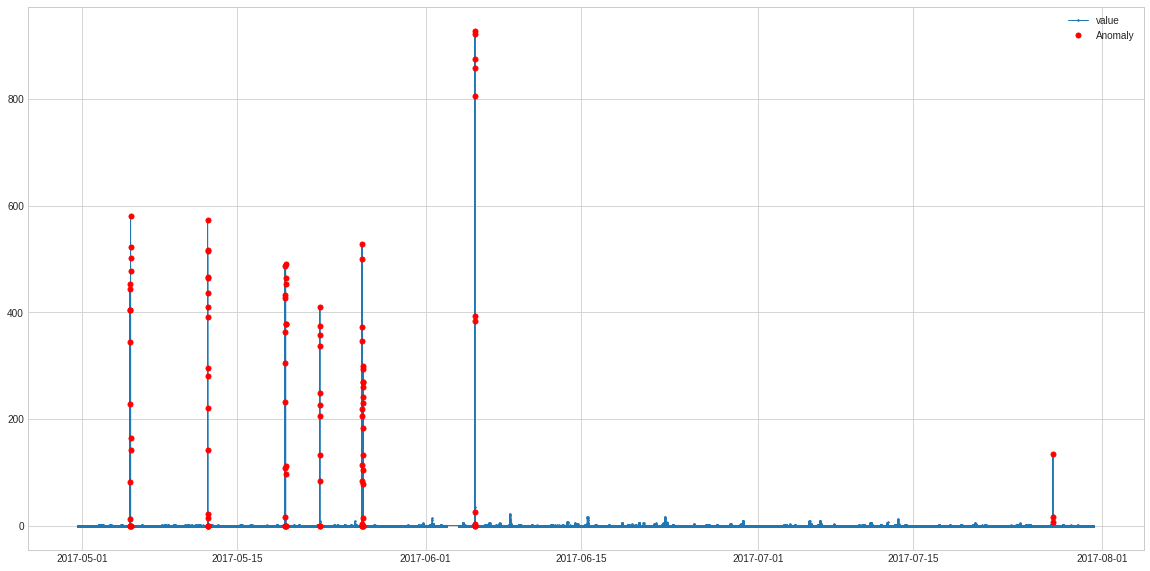

In [49]:
#Isolation Forest Best
best_if = performance_df['Isolation Forest'].sort_values().index[-1]
best_data = train.loc[train['KPI ID'] == best_if, :]
best_data.timestamp = best_data.timestamp.apply(lambda x: datetime.fromtimestamp(x))
best_data.index = best_data.timestamp
c = contamination_dict[best_if]
anomalies = detector.isolation_f(best_data.value, c)
print('Ground Truth')
plot(best_data.value, anomaly=best_data.label, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Predicted


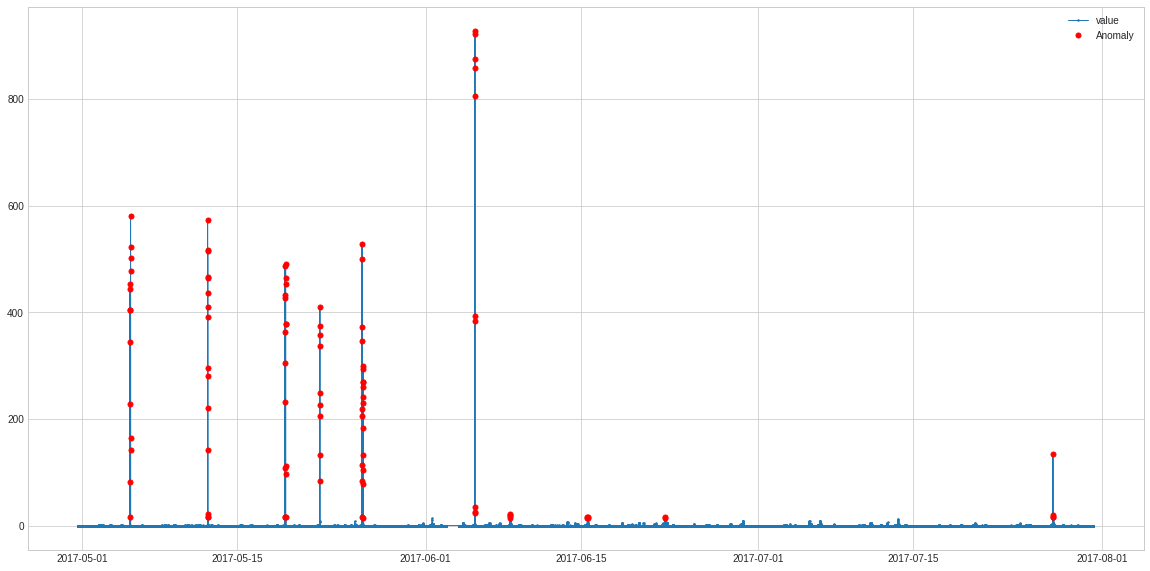

In [50]:
print('Predicted')
plot(best_data.value, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Here isolation forest does quite well and it's not surprising. This case has no seasonality and the outliers are clearly visible.There's no context to understand, so 1 feature isolation forest is ineed the best choice. Let's see where it fails to perform well.

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Ground Truth


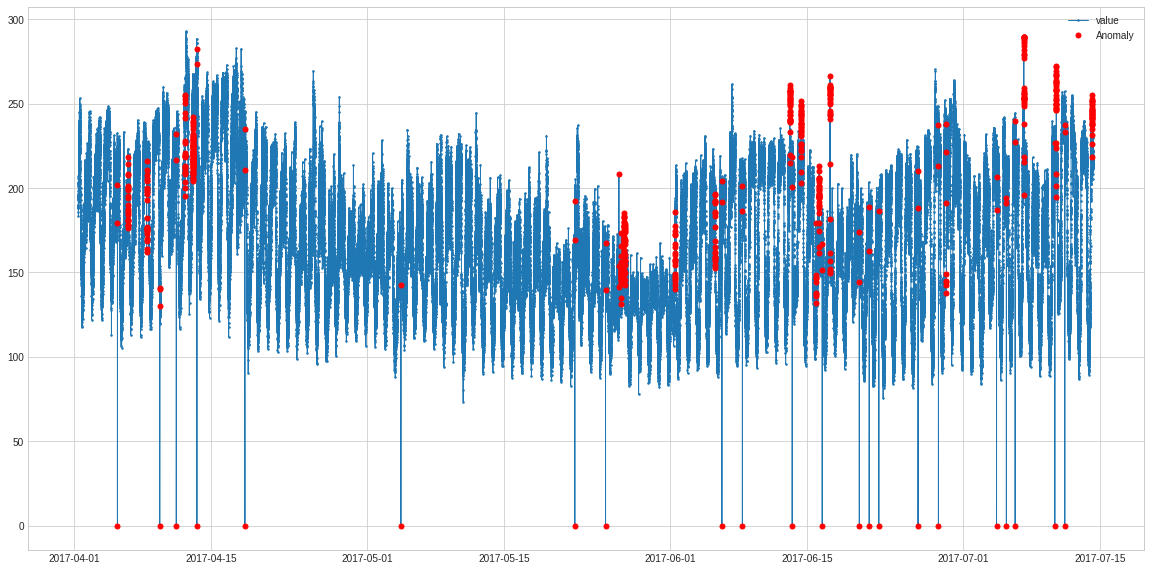

In [51]:
#Isolation Forest Worst
worst_if = performance_df['Isolation Forest'].sort_values().index[0]
worst_data = train.loc[train['KPI ID'] == worst_if, :]
worst_data.timestamp = worst_data.timestamp.apply(lambda x: datetime.fromtimestamp(x))
worst_data.index = worst_data.timestamp
c = contamination_dict[worst_if]
anomalies = detector.isolation_f(worst_data.value, c)
print('Ground Truth')
plot(worst_data.value, anomaly=worst_data.label, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Predicted


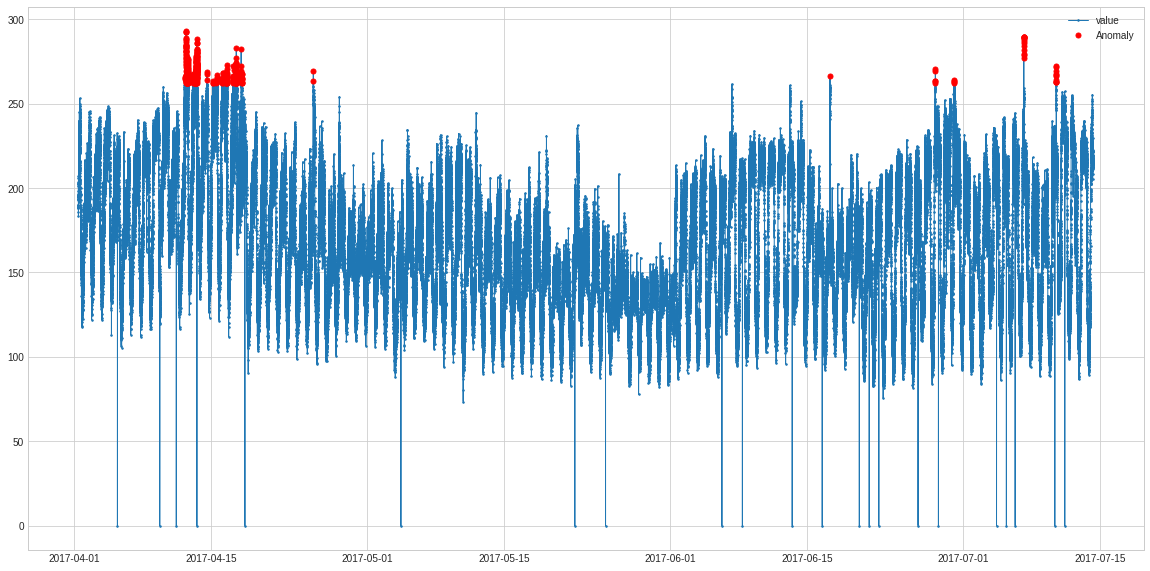

In [52]:
print('Predicted')
plot(worst_data.value, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

In the contrast to the previous series, this one has clear seasonality and level shifts in it. Isolation forest fails to detect most fo the outliers, hence it should not be used in the case of complex time series (at least without any adjustments)

### Seasonal Model Exploration

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Ground Truth


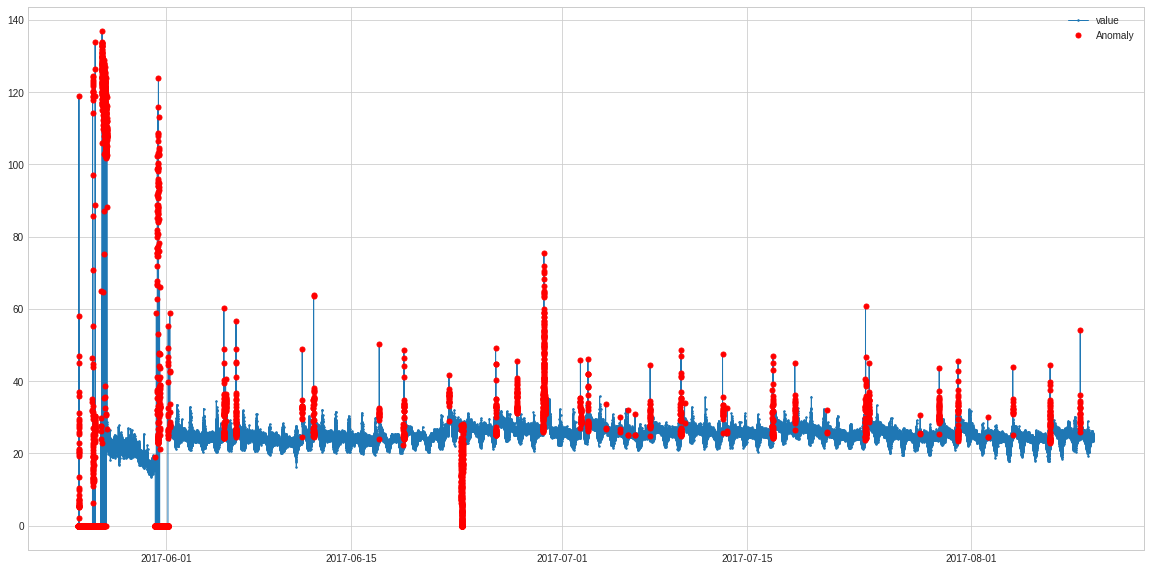

In [53]:
#Seasonal Best
best_seasonal = performance_df['Seasonal Model'].sort_values().index[-1]
best_data = train.loc[train['KPI ID'] == best_seasonal, :]
best_data.timestamp = best_data.timestamp.apply(lambda x: datetime.fromtimestamp(x))
best_data.index = best_data.timestamp
c = contamination_dict[best_seasonal]
anomalies = detector.seasonal(best_data.value.resample(pd.infer_freq(best_data.index[:5])).sum())
print('Ground Truth')
plot(best_data.value, anomaly=best_data.label, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Predicted


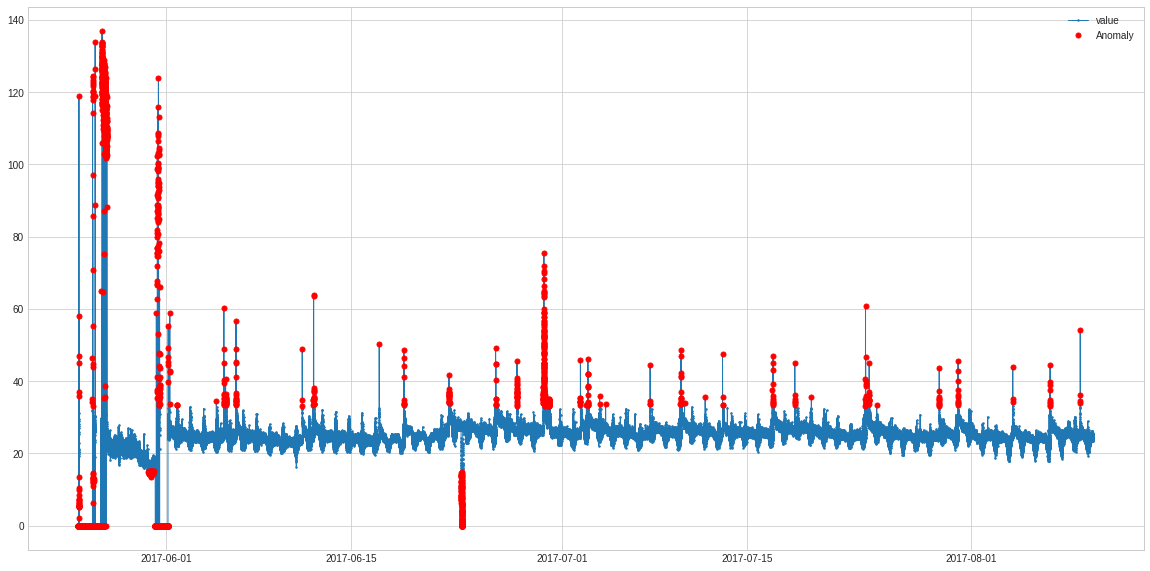

In [54]:
print('Predicted')
plot(best_data.value, anomaly=anomalies[best_data.index], ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Here the data clearly has seasonal patterns, so the seasonal model is the best choice here. Setting simple thresholds or using rolling averages wouldn't work here, so detecting seasonality in these kinds of data is crucial. Now, let's see where seasonal model won't help us in finding the anomalies. 

Ground Truth


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


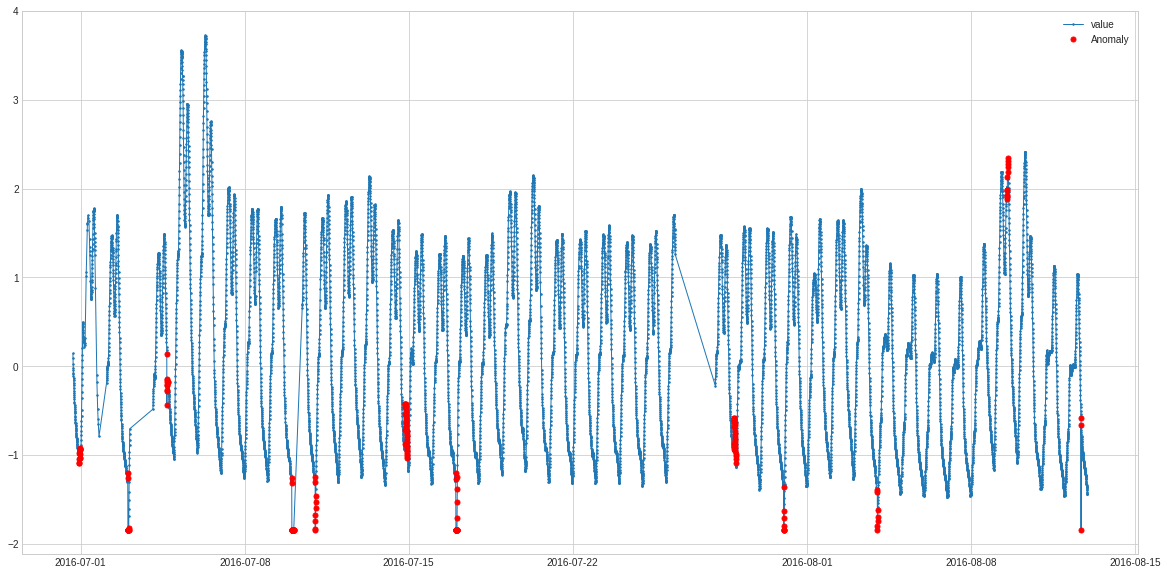

In [55]:
#Seasoanl Worst
worst_seasonal = performance_df['Seasonal Model'].sort_values().index[0]
worst_data = train.loc[train['KPI ID'] == worst_seasonal, :]
worst_data.timestamp = worst_data.timestamp.apply(lambda x: datetime.fromtimestamp(x))
worst_data.index = worst_data.timestamp
c = contamination_dict[worst_seasonal]
anomalies = detector.seasonal(worst_data.value.resample(pd.infer_freq(worst_data.index[:5])).sum())
print('Ground Truth')
plot(worst_data.value, anomaly=worst_data.label, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Predicted


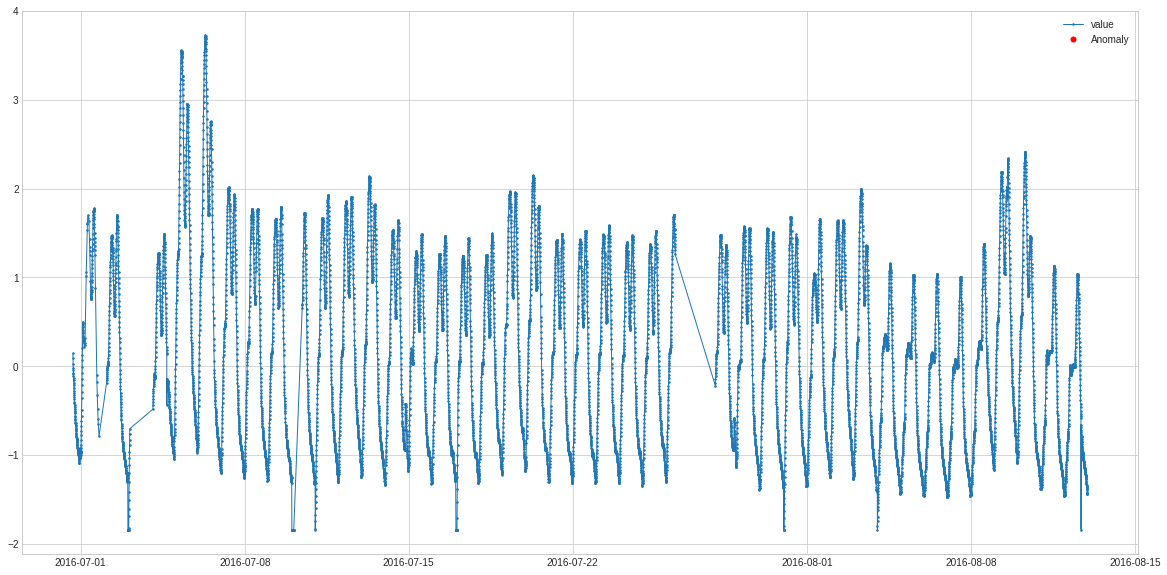

In [56]:
print('Predicted')
plot(worst_data.value, anomaly=anomalies[worst_data.index], ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

This type of data highly irregular as it clearly has some missing data points. Also the seasonal pattern changes and is hard to establish to begin with. It's not surprising as simple time series decomposition failed as this type of data requires more sophisticated models.

Overall, it is clear that you need to know your data before deciding on the anomaly detection algorithm. Further steps could involve adding contextual data to HDBSCAN and Isolation Forest since they can take basically any number of variables.

#### Conclusion
We’ve seen 3 new unsupervised anomaly detection algorithms. Two of them are based on the idea of distance and density while the Isolation Forest is a completely novel algorithm relying on the number of splits. As you saw in the example, each algorithm detects somewhat different type of outliers, so make sure to understand your data and experiment before choosing the algorithm. From the comparison on labelled dataset, we saw that Isolation Forest and Seasonal Models have better performance than other algorithms but again, they have quite large standard deviations and work for some datasets while failing on other ones. Hence, when you are working with other datasets, you can start with these two models, get the benchmark, and begin your exploration.